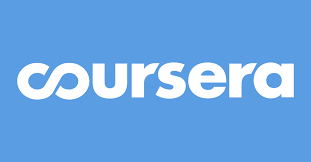

<h1><center>Capstone Project: The Battle of Neighborhoods</center></h1>

## Table of Contents

This notebook contains the following parts:

<div class="alert alert-block alert-info" style="margin-top: 20px">
<font size = 3>

1. [Introduction](#introduction)  
   1.1 [Background](#background)  
   1.2 [Specific problem to solve](#specific_problem_to_solve)  
   1.3 [Interested audience](#interested_audience)
2. [Data](#data)
3. [Methodology](#methodology)  
   3.1 [Import rental information and clean the data](#rental)  
   3.2 [Crime rate data scraping](#crime_rate)  
   3.3 [Explore the restaurant venues nearby](#venues)
4. [Results](#results)
5. [Discussion and Conclusion](#discussion_and_conclusion)
   
</font>
</div>

## 1. Introduction <a class="anchor" id="introduction"></a>

### 1.1 Background<a class="anchor" id="background"></a>

Nowadays, due to various reasons, people tend to move from one city to another, or even from one country to another. However, sometimes people are not quite familiar with the new country or city that they are going to move to. So in order to help people decide where to live, information associated with people's requirements (eg: distance from workplace, monthly rent, crime rate, restaurants nearby) need to be gathered. Futhermore, based on personal preference, optimal options should be generated for people to choose. 

### 1.2 Specific problem to solve<a class="anchor" id="specific_problem_to_solve"></a>

I would like to find a suitable place to live in New York city. There are several requirements that I hope the potential rental place can meet.
1. I hope the monthly rent won't be higher than US $2000. 
2. The distance between New York university (70 Washington Square South New York, NY) and the rental place is within 3 miles.
3. Safety is a critical issue, so I would also choose those have lower crime rates.
4. Since I prefer Asian food, especially Chinese food and Japanese food, it will be great if there are great Chinese and Japanese food restaurants nearby.

### 1.3 Interested audience<a class="anchor" id="interested_audience"></a>

Although the outcome is a case-by-case suggestion, depending on the requirements of different people in different city or country, the general methodologies are applicable to all cases. Anyone who would like to get customized suggestions in where to live will find it to be beneficial.

## 2. Data<a class="anchor" id="data"></a>

We will need the following data for this project:
1. Using www.rent.com website, I searched rental place near New York university, with US$2000 as the maximum monthly rent. House renting data containing name of rental place, address, type and price are scraped from https://www.rent.com/new-york/new-york-university-houses/max-price-2000, and saved as **"rent_data_mining.csv"**.
2. Get the coordinations of places for rent using **foursquare agent**.
3. Gather both **violent crime rate** and **property crime rate** for those potential rental places. I will use **beautifulsoup 4** to scrape the cirme rates from the following website https://www.bestplaces.net/crime/zip-code/new_york/new_york/11210, and change the zip code according to different potential rental places. 
4. Restaurants information (venue, venue id, venue category and rating) are obtained from **foursquare API**.

## 3. Methodology<a class="anchor" id="methodology"></a>

This section represents the main component of the report where the data is gathered, prepared for analysis. The tools described are used here and the notebook cells indicate the execution of steps.

The analysis and the stragegy:
The strategy is based on filtering data in section 2, in order to facilitate the choice of at least two candidate places for rent. The choice is made based on the demands imposed : monthly rental price, distance from New York university, crime rate and restaurants nearby. The maps with popup labels allow quick identification of location, thus making the selection more straightforward.

### Import necessary libraries.

In [1]:
import requests # library to handle requests
import pandas as pd # library for data analsysis
import numpy as np # library to handle data in a vectorized manner
import re

#!conda install -c conda-forge geopy --yes 
from geopy.geocoders import Nominatim # module to convert an address into latitude and longitude values

print('Libraries imported.')

Libraries imported.


### Define Foursquare Credentials and Version

In [2]:
# @hidden_cell
CLIENT_ID = 'UOQC5VBGMXKL0MWLS***********************' # your Foursquare ID
CLIENT_SECRET = 'HH4WDD4VPMN0RG3ZIANAZY*****************' # your Foursquare Secret
VERSION = '20190607'
Limit = 30
#print('Your credentails:')
#print('CLIENT_ID: ' + CLIENT_ID)
#print('CLIENT_SECRET:' + CLIENT_SECRET)

In order to explore near New York university, let's start by converting the its address to its latitude and longitude coordinates.¶

In [3]:
address = '70 Washington Square South New York, NY'

geolocator = Nominatim(user_agent="foursquare_agent")
location = geolocator.geocode(address)
NYU_latitude = location.latitude
NYU_longitude = location.longitude
print('New York University''s latitude is:',NYU_latitude)
print('New York University''s longitude is:',NYU_longitude)

New York Universitys latitude is: 40.72942865
New York Universitys longitude is: -73.9972178045625


### 3.1 Import rental information and clean the data<a class="anchor" id="rental"></a>

I scraped the rental information from www.rent.com and saved into **rent_data_mining.csv**. Note: I have already applied the first requirement, which is the monthly rent is not higher than US $2000. So now, I need to import this file.

In [4]:
import types
import pandas as pd
from botocore.client import Config
import ibm_boto3

def __iter__(self): return 0

# @hidden_cell
# The following code accesses a file in your IBM Cloud Object Storage. It includes your credentials.
# You might want to remove those credentials before you share your notebook.
client_********* = ibm_boto3.client(service_name='s3',
    ibm_api_key_id='***********',
    ibm_auth_endpoint="https://iam.bluemix.net/oidc/token",
    config=Config(signature_version='oauth'),
    endpoint_url='https://s3-api.us-geo.objectstorage.service.networklayer.com')

body = client_**********.get_object(Bucket='******',Key='rent_2k.csv')['Body']
# add missing __iter__ method, so pandas accepts body as file-like object
if not hasattr(body, "__iter__"): body.__iter__ = types.MethodType( __iter__, body )

In [5]:
df = pd.read_csv(body)
df.head()

,Name,Address,Type,Price
0,1 Pennsylvania Plaza,"New York, NY 10119",3 Beds • 1 Bath,"$1,750.00"
1,139A Jefferson Ave,"Brooklyn, NY 11216",1 Bed • 1 Bath,$975.00
2,6605 Boulevard E,"West New York, NJ 07093",1 Bed • 1 Bath,"$1,450.00"
3,41-07 42nd St,"Queens, NY 11104",Studio • 1 Bath,"$1,685.00"
4,212 Lewis Ave,"Brooklyn, NY 11221",1 Bed • 1 Bath,"$1,600.00"


In [6]:
df.shape

(237, 4)

Let's simply focused on rental places in New York city.

In [7]:
df_1 = df[df['Address'].str.contains("NY")]
df_1
df_1.shape

(82, 4)

Since I would like to live alone, I prefer to choose either **"1 Bed, 1Bath"** or **"Studio, 1 Bath"** types.

In [8]:
df_2 = df_1[df_1['Type'].str.contains("Studio")| df_1['Type'].str.contains("1 Bed")]
df_2
#df_2.shape

,Name,Address,Type,Price
1,139A Jefferson Ave,"Brooklyn, NY 11216",1 Bed • 1 Bath,$975.00
3,41-07 42nd St,"Queens, NY 11104",Studio • 1 Bath,"$1,685.00"
4,212 Lewis Ave,"Brooklyn, NY 11221",1 Bed • 1 Bath,"$1,600.00"
6,56-72 64th St,"Queens, NY 11378",1 Bed • 1 Bath,"$1,900.00"
7,174 Mulberry St 2,"174 Mulberry St New York, NY 10013",Studio • 1 Bath,"$1,650.00"
8,510 E 5th St B,"510 E 5th St New York, NY 10009",Studio • 1 Bath,"$1,975.00"
9,226 E 26th St B-E,"226 E 26th St New York, NY 10010",Studio • 1 Bath,"$1,825.00"
10,152 E 35th St 6-H,"152 E 35th St New York, NY 10016",Studio • 1 Bath,"$1,975.00"
11,5 Tudor City Pl 306,"5 Tudor City Pl New York, NY 10017",Studio • 1 Bath,"$1,800.00"
12,25 Tudor City Pl 1206,"25 Tudor City Pl New York, NY 10017",Studio • 1 Bath,"$1,950.00"


I would like to get all the addresses of these rental places, so that I can get the coordination information later.

In [9]:
ad_list = df_2['Address'].tolist()
ad_list

['Brooklyn, NY 11216',
 'Queens, NY 11104',
 'Brooklyn, NY 11221',
 'Queens, NY 11378',
 '174 Mulberry St New York, NY 10013',
 '510 E 5th St New York, NY 10009',
 '226 E 26th St New York, NY 10010',
 '152 E 35th St New York, NY 10016',
 '5 Tudor City Pl New York, NY 10017',
 '25 Tudor City Pl New York, NY 10017',
 '349 W 45th St New York, NY 10036',
 '297 Broadway Brooklyn, NY 11211',
 '81 Waverly Ave Brooklyn, NY 11205',
 '177 Congress St Brooklyn, NY 11201',
 '430 E 66th St New York, NY 10065',
 '28 Carroll St Brooklyn, NY 11231',
 '698 Fulton St Brooklyn, NY 11217',
 '403 E 70th St New York, NY 10021',
 '23-10 41st Ave Queens, NY 11101',
 '482 E 74th St New York, NY 10021',
 '1431 1st Avenue New York, NY 10021',
 '94 3rd Pl Brooklyn, NY 11231',
 '1313 3rd Ave New York, NY 10021',
 '328 E 77th St New York, NY 10075',
 '418 E 77th St New York, NY 10075',
 '38-05 Crescent St Queens, NY 11101',
 '223 E 78th St New York, NY 10075',
 '448 E 78th St New York, NY 10075',
 '158 6th Ave Broo

To get the coordination information for those rental places, I need to use the **foursquare agent**.

In [10]:
la_list = list()
lo_list = list()
for ad in ad_list:
    geolocator = Nominatim(user_agent="foursquare_agent")
    location = geolocator.geocode(ad)
    #if location is not None and location.latitude is not None:
    latitude = location.latitude
    longitude = location.longitude
    la_list.append(latitude)
    lo_list.append(longitude)
#print(la_list)
#print(lo_list)
print('The number of latitude obtained is:',len(la_list))
print('The number of longitude obtained is:',len(lo_list))  

The number of latitude obtained is: 77
The number of longitude obtained is: 77


In [11]:
# Write the latitude and longitude information into dataframe.
df_2['Latitude'] = la_list
df_2['Longitude'] = lo_list
df_2

/opt/conda/envs/DSX-Python35/lib/python3.5/site-packages/ipykernel/__main__.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from ipykernel import kernelapp as app
/opt/conda/envs/DSX-Python35/lib/python3.5/site-packages/ipykernel/__main__.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  app.launch_new_instance()


,Name,Address,Type,Price,Latitude,Longitude
1,139A Jefferson Ave,"Brooklyn, NY 11216",1 Bed • 1 Bath,$975.00,40.650104,-73.949582
3,41-07 42nd St,"Queens, NY 11104",Studio • 1 Bath,"$1,685.00",40.652493,-73.791421
4,212 Lewis Ave,"Brooklyn, NY 11221",1 Bed • 1 Bath,"$1,600.00",40.650104,-73.949582
6,56-72 64th St,"Queens, NY 11378",1 Bed • 1 Bath,"$1,900.00",40.652493,-73.791421
7,174 Mulberry St 2,"174 Mulberry St New York, NY 10013",Studio • 1 Bath,"$1,650.00",40.719998,-73.996902
8,510 E 5th St B,"510 E 5th St New York, NY 10009",Studio • 1 Bath,"$1,975.00",40.724452,-73.983861
9,226 E 26th St B-E,"226 E 26th St New York, NY 10010",Studio • 1 Bath,"$1,825.00",40.739994,-73.980549
10,152 E 35th St 6-H,"152 E 35th St New York, NY 10016",Studio • 1 Bath,"$1,975.00",40.746509,-73.978469
11,5 Tudor City Pl 306,"5 Tudor City Pl New York, NY 10017",Studio • 1 Bath,"$1,800.00",40.748640,-73.970494
12,25 Tudor City Pl 1206,"25 Tudor City Pl New York, NY 10017",Studio • 1 Bath,"$1,950.00",40.748636,-73.970505


In [12]:
df_2.to_csv('rent_lat_lng.csv')

In [13]:
!conda install -c conda-forge folium=0.5.0 --yes
import folium # plotting library
print('Folium imported!')

Solving environment: done

## Package Plan ##

  environment location: /opt/conda/envs/DSX-Python35

  added / updated specs: 
    - folium=0.5.0


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    altair-2.2.2               |           py35_1         462 KB  conda-forge
    folium-0.5.0               |             py_0          45 KB  conda-forge
    openssl-1.0.2r             |       h14c3975_0         3.1 MB  conda-forge
    ca-certificates-2019.6.16  |       hecc5488_0         145 KB  conda-forge
    certifi-2018.8.24          |        py35_1001         139 KB  conda-forge
    branca-0.3.1               |             py_0          25 KB  conda-forge
    vincent-0.4.4              |             py_1          28 KB  conda-forge
    ------------------------------------------------------------
                                           Total:         4.0 MB

The following NEW packages will

Now, let's have a look at the locations of these rental places and have a rough idea about the distance between the rental place and New York University respectively.

In [14]:
rental_map = folium.Map(location=[NYU_latitude, NYU_longitude], zoom_start=13) # generate map centred around the New York University

# add a red circle marker to represent the New York University
folium.features.CircleMarker(
    [NYU_latitude, NYU_longitude],
    radius=10,
    color='red',
    popup='New York University',
    fill = True,
    fill_color = 'red',
    fill_opacity = 0.6
).add_to(rental_map)

# add the Italian restaurants as blue circle markers
for address, lat, lng in zip(df_2.Address, df_2.Latitude, df_2.Longitude):
    folium.features.CircleMarker(
        [lat, lng],
        radius=5,
        color='blue',
        popup=address,
        fill = True,
        fill_color='blue',
        fill_opacity=0.6
    ).add_to(rental_map)

# display map
rental_map

Since now Google starts to charge for their Google Maps Geocoding API, I need to use geopy.distance to get the distance between the rental place and New York University.

In [15]:
from geopy.distance import distance
print('Imported!')

Imported!


In [16]:
coordination_list = list(zip(df_2['Latitude'], df_2['Longitude']))
coordination_list

[(40.6501038, -73.9495823),
 (40.6524927, -73.7914214158161),
 (40.6501038, -73.9495823),
 (40.6524927, -73.7914214158161),
 (40.7199982, -73.9969021),
 (40.72445225, -73.9838607811497),
 (40.73999425, -73.9805487493491),
 (40.7465088, -73.9784688900236),
 (40.7486403, -73.9704935),
 (40.7486361, -73.9705045934066),
 (40.760182, -73.9902720834181),
 (40.708554, -73.958006),
 (40.69523095, -73.9680248191945),
 (40.6884753, -73.9956456905611),
 (40.76325425, -73.9574944331219),
 (40.6832151, -74.0048201706379),
 (40.685934, -73.9740013),
 (40.76643095, -73.9562745618977),
 (40.7525859, -73.9401946),
 (40.7684321, -73.9538842184601),
 (40.7693997, -73.9551854834534),
 (40.67858985, -73.9982194410135),
 (40.77175465, -73.9587923343222),
 (40.6297445714286, -74.0275684285714),
 (40.6290073061225, -74.0252030204082),
 (40.7555337, -73.9359009),
 (40.77327415, -73.956618550178),
 (40.77076615, -73.9515355515006),
 (40.6771488, -73.977079643265),
 (40.6781126, -73.9729088),
 (40.7704863, -73.9

In [17]:
NYU = (40.72942865,-73.9972178045625)
DISTANCE_LIST = list()
for coordination in coordination_list:
    d = distance(NYU,coordination)
    DISTANCE_LIST.append(d.miles)
print(DISTANCE_LIST)
len(DISTANCE_LIST)

[6.018297972964093, 12.042266813340438, 6.018297972964093, 12.042266813340438, 0.6509346547204209, 0.7807362197929842, 1.1388675913973203, 1.535379353555283, 1.9299484570031737, 1.9293262822948352, 2.153141462115093, 2.5125206016757207, 2.8138496771103356, 2.827076954811914, 3.1294677661577985, 3.2137261171128104, 3.239371784720339, 3.337013913287653, 3.392633029802341, 3.5234198943497184, 3.5316221948177553, 3.508380646717996, 3.5490624097797974, 7.060750238049578, 7.083491872723959, 3.6878897882462076, 3.7003005911023106, 3.7259740764864797, 3.7592318658660995, 3.7639897486653897, 3.809045962267381, 7.268931092528627, 3.9076747978742894, 3.9222396426689685, 3.9447628496328684, 3.968467881950467, 3.968467881950467, 3.968467881950467, 3.968467881950467, 3.9598942111670783, 3.9707313342148796, 4.048689647400895, 4.105068101171428, 4.128694496855742, 4.1744744876186735, 12.042266813340438, 7.618722916053908, 4.20576368137502, 4.181223745907076, 4.2233006365001655, 4.2697526751059796, 4.2

77

In [18]:
df_2['Distance from NYU (miles)'] = DISTANCE_LIST
df_2

/opt/conda/envs/DSX-Python35/lib/python3.5/site-packages/ipykernel/__main__.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':


,Name,Address,Type,Price,Latitude,Longitude,Distance from NYU (miles)
1,139A Jefferson Ave,"Brooklyn, NY 11216",1 Bed • 1 Bath,$975.00,40.650104,-73.949582,6.018298
3,41-07 42nd St,"Queens, NY 11104",Studio • 1 Bath,"$1,685.00",40.652493,-73.791421,12.042267
4,212 Lewis Ave,"Brooklyn, NY 11221",1 Bed • 1 Bath,"$1,600.00",40.650104,-73.949582,6.018298
6,56-72 64th St,"Queens, NY 11378",1 Bed • 1 Bath,"$1,900.00",40.652493,-73.791421,12.042267
7,174 Mulberry St 2,"174 Mulberry St New York, NY 10013",Studio • 1 Bath,"$1,650.00",40.719998,-73.996902,0.650935
8,510 E 5th St B,"510 E 5th St New York, NY 10009",Studio • 1 Bath,"$1,975.00",40.724452,-73.983861,0.780736
9,226 E 26th St B-E,"226 E 26th St New York, NY 10010",Studio • 1 Bath,"$1,825.00",40.739994,-73.980549,1.138868
10,152 E 35th St 6-H,"152 E 35th St New York, NY 10016",Studio • 1 Bath,"$1,975.00",40.746509,-73.978469,1.535379
11,5 Tudor City Pl 306,"5 Tudor City Pl New York, NY 10017",Studio • 1 Bath,"$1,800.00",40.748640,-73.970494,1.929948
12,25 Tudor City Pl 1206,"25 Tudor City Pl New York, NY 10017",Studio • 1 Bath,"$1,950.00",40.748636,-73.970505,1.929326


Since now I know the distance from NYU, then I can drop those places whose distance is greater than 3 miles.

In [19]:
drop_index = df_2[df_2['Distance from NYU (miles)']>3].index # To get the index of rows with distance larger than expected value.
df_2.drop(drop_index , inplace=True)
df_2

/opt/conda/envs/DSX-Python35/lib/python3.5/site-packages/ipykernel/__main__.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from ipykernel import kernelapp as app


,Name,Address,Type,Price,Latitude,Longitude,Distance from NYU (miles)
7,174 Mulberry St 2,"174 Mulberry St New York, NY 10013",Studio • 1 Bath,"$1,650.00",40.719998,-73.996902,0.650935
8,510 E 5th St B,"510 E 5th St New York, NY 10009",Studio • 1 Bath,"$1,975.00",40.724452,-73.983861,0.780736
9,226 E 26th St B-E,"226 E 26th St New York, NY 10010",Studio • 1 Bath,"$1,825.00",40.739994,-73.980549,1.138868
10,152 E 35th St 6-H,"152 E 35th St New York, NY 10016",Studio • 1 Bath,"$1,975.00",40.746509,-73.978469,1.535379
11,5 Tudor City Pl 306,"5 Tudor City Pl New York, NY 10017",Studio • 1 Bath,"$1,800.00",40.748640,-73.970494,1.929948
12,25 Tudor City Pl 1206,"25 Tudor City Pl New York, NY 10017",Studio • 1 Bath,"$1,950.00",40.748636,-73.970505,1.929326
24,349 W 45th St BW,"349 W 45th St New York, NY 10036",1 Bed • 1 Bath,"$1,750.00",40.760182,-73.990272,2.153141
34,297 Broadway 3F,"297 Broadway Brooklyn, NY 11211",1 Bed • 1 Bath,"$2,000.00",40.708554,-73.958006,2.512521
48,81 Waverly Ave 3,"81 Waverly Ave Brooklyn, NY 11205",Studio • 1 Bath,"$1,850.00",40.695231,-73.968025,2.813850
50,177 Congress St 4,"177 Congress St Brooklyn, NY 11201",Studio • 1 Bath,"$2,000.00",40.688475,-73.995646,2.827077


Let's sort the data by price and distance from NYU (miles) in ascending order.

In [20]:
df_3 = df_2.sort_values(by=['Price', 'Distance from NYU (miles)'])
df_3

,Name,Address,Type,Price,Latitude,Longitude,Distance from NYU (miles)
7,174 Mulberry St 2,"174 Mulberry St New York, NY 10013",Studio • 1 Bath,"$1,650.00",40.719998,-73.996902,0.650935
24,349 W 45th St BW,"349 W 45th St New York, NY 10036",1 Bed • 1 Bath,"$1,750.00",40.760182,-73.990272,2.153141
11,5 Tudor City Pl 306,"5 Tudor City Pl New York, NY 10017",Studio • 1 Bath,"$1,800.00",40.748640,-73.970494,1.929948
9,226 E 26th St B-E,"226 E 26th St New York, NY 10010",Studio • 1 Bath,"$1,825.00",40.739994,-73.980549,1.138868
48,81 Waverly Ave 3,"81 Waverly Ave Brooklyn, NY 11205",Studio • 1 Bath,"$1,850.00",40.695231,-73.968025,2.813850
12,25 Tudor City Pl 1206,"25 Tudor City Pl New York, NY 10017",Studio • 1 Bath,"$1,950.00",40.748636,-73.970505,1.929326
8,510 E 5th St B,"510 E 5th St New York, NY 10009",Studio • 1 Bath,"$1,975.00",40.724452,-73.983861,0.780736
10,152 E 35th St 6-H,"152 E 35th St New York, NY 10016",Studio • 1 Bath,"$1,975.00",40.746509,-73.978469,1.535379
34,297 Broadway 3F,"297 Broadway Brooklyn, NY 11211",1 Bed • 1 Bath,"$2,000.00",40.708554,-73.958006,2.512521
50,177 Congress St 4,"177 Congress St Brooklyn, NY 11201",Studio • 1 Bath,"$2,000.00",40.688475,-73.995646,2.827077


In [21]:
df_3 = df_3.reset_index(drop=True)
df_3

,Name,Address,Type,Price,Latitude,Longitude,Distance from NYU (miles)
0,174 Mulberry St 2,"174 Mulberry St New York, NY 10013",Studio • 1 Bath,"$1,650.00",40.719998,-73.996902,0.650935
1,349 W 45th St BW,"349 W 45th St New York, NY 10036",1 Bed • 1 Bath,"$1,750.00",40.760182,-73.990272,2.153141
2,5 Tudor City Pl 306,"5 Tudor City Pl New York, NY 10017",Studio • 1 Bath,"$1,800.00",40.748640,-73.970494,1.929948
3,226 E 26th St B-E,"226 E 26th St New York, NY 10010",Studio • 1 Bath,"$1,825.00",40.739994,-73.980549,1.138868
4,81 Waverly Ave 3,"81 Waverly Ave Brooklyn, NY 11205",Studio • 1 Bath,"$1,850.00",40.695231,-73.968025,2.813850
5,25 Tudor City Pl 1206,"25 Tudor City Pl New York, NY 10017",Studio • 1 Bath,"$1,950.00",40.748636,-73.970505,1.929326
6,510 E 5th St B,"510 E 5th St New York, NY 10009",Studio • 1 Bath,"$1,975.00",40.724452,-73.983861,0.780736
7,152 E 35th St 6-H,"152 E 35th St New York, NY 10016",Studio • 1 Bath,"$1,975.00",40.746509,-73.978469,1.535379
8,297 Broadway 3F,"297 Broadway Brooklyn, NY 11211",1 Bed • 1 Bath,"$2,000.00",40.708554,-73.958006,2.512521
9,177 Congress St 4,"177 Congress St Brooklyn, NY 11201",Studio • 1 Bath,"$2,000.00",40.688475,-73.995646,2.827077


ZipCode needs to be extracted and saved to the dataframe for further use.

In [22]:
df_3['ZipCode'] = df_3['Address'].str.extract('(\d{5})', expand=True)
df_3

,Name,Address,Type,Price,Latitude,Longitude,Distance from NYU (miles),ZipCode
0,174 Mulberry St 2,"174 Mulberry St New York, NY 10013",Studio • 1 Bath,"$1,650.00",40.719998,-73.996902,0.650935,10013
1,349 W 45th St BW,"349 W 45th St New York, NY 10036",1 Bed • 1 Bath,"$1,750.00",40.760182,-73.990272,2.153141,10036
2,5 Tudor City Pl 306,"5 Tudor City Pl New York, NY 10017",Studio • 1 Bath,"$1,800.00",40.748640,-73.970494,1.929948,10017
3,226 E 26th St B-E,"226 E 26th St New York, NY 10010",Studio • 1 Bath,"$1,825.00",40.739994,-73.980549,1.138868,10010
4,81 Waverly Ave 3,"81 Waverly Ave Brooklyn, NY 11205",Studio • 1 Bath,"$1,850.00",40.695231,-73.968025,2.813850,11205
5,25 Tudor City Pl 1206,"25 Tudor City Pl New York, NY 10017",Studio • 1 Bath,"$1,950.00",40.748636,-73.970505,1.929326,10017
6,510 E 5th St B,"510 E 5th St New York, NY 10009",Studio • 1 Bath,"$1,975.00",40.724452,-73.983861,0.780736,10009
7,152 E 35th St 6-H,"152 E 35th St New York, NY 10016",Studio • 1 Bath,"$1,975.00",40.746509,-73.978469,1.535379,10016
8,297 Broadway 3F,"297 Broadway Brooklyn, NY 11211",1 Bed • 1 Bath,"$2,000.00",40.708554,-73.958006,2.512521,11211
9,177 Congress St 4,"177 Congress St Brooklyn, NY 11201",Studio • 1 Bath,"$2,000.00",40.688475,-73.995646,2.827077,11201


In [23]:
df_3.to_csv('rental_distance_zipcode.csv')

Now let's visualize the filtered rental places on the map.

In [24]:
rental_filtered_map = folium.Map(location=[NYU_latitude, NYU_longitude], zoom_start=13) # generate map centred around the New York University

# add a red circle marker to represent the New York University
folium.features.CircleMarker(
    [NYU_latitude, NYU_longitude],
    radius=10,
    color='red',
    popup='New York University',
    fill = True,
    fill_color = 'red',
    fill_opacity = 0.6
).add_to(rental_filtered_map)

# add the Italian restaurants as blue circle markers
for address, lat, lng in zip(df_3.Address, df_3.Latitude, df_3.Longitude):
    folium.features.CircleMarker(
        [lat, lng],
        radius=5,
        color='blue',
        popup=address,
        fill = True,
        fill_color='blue',
        fill_opacity=0.6
    ).add_to(rental_filtered_map)

# display map
rental_filtered_map

### 3.2 Crime rate data scraping<a class="anchor" id="crime_rate"></a>

Safety is a critical issue that I would like to consider when deciding where to live. So I need to get the both **violent crime rate** and **property crime rate** for those potential rental places. I will use the following website https://www.bestplaces.net/crime/zip-code/new_york/new_york/11210 and zip code of those rental places to scrape the crime rates. To do so, I choose to use **beautifulsoup4**.

In [25]:
import bs4 # beautifulsoup4 to scrap webpage
import urllib.request

After importing the necessary libraries, zip code from dataframe will be saved as **zipcode_list** for scrapping webpages.

In [26]:
zipcode_list=df_3['ZipCode'].tolist()
zipcode_list

['10013',
 '10036',
 '10017',
 '10010',
 '11205',
 '10017',
 '10009',
 '10016',
 '11211',
 '11201']

In [27]:
import urllib.parse
url = 'https://www.bestplaces.net/crime/zip-code/new_york/new_york/11210'
parts = urllib.parse.urlparse(url) # To parse the components of url.
#print(parts)

path_list = ['/crime/zip-code/new_york/new_york/' + zipcode for zipcode in zipcode_list] # To add the path in front of zipcode and create a list.
#print(path_list)
url_list=[]
for p in path_list:
    parts = parts._replace(path=p) # Replace the path with new path with different zipcode.
    url_list.append(parts.geturl())# Get urls and save them into a new list.
print(url_list)

['https://www.bestplaces.net/crime/zip-code/new_york/new_york/10013', 'https://www.bestplaces.net/crime/zip-code/new_york/new_york/10036', 'https://www.bestplaces.net/crime/zip-code/new_york/new_york/10017', 'https://www.bestplaces.net/crime/zip-code/new_york/new_york/10010', 'https://www.bestplaces.net/crime/zip-code/new_york/new_york/11205', 'https://www.bestplaces.net/crime/zip-code/new_york/new_york/10017', 'https://www.bestplaces.net/crime/zip-code/new_york/new_york/10009', 'https://www.bestplaces.net/crime/zip-code/new_york/new_york/10016', 'https://www.bestplaces.net/crime/zip-code/new_york/new_york/11211', 'https://www.bestplaces.net/crime/zip-code/new_york/new_york/11201']


Using the url_list, I scrape the webpage respectively to get violent crime rate and property crime rate.

In [28]:
from bs4 import BeautifulSoup
vc_rate=[]
pc_rate=[]
for zip_url in url_list:
    website_url = requests.get(zip_url).text
    soup = BeautifulSoup(website_url,'lxml')
#print(soup.prettify())
 
    rate = soup.find_all('h5')
    #print(rate[1],rate[2])
    v_rate = re.findall("\d+\.\d+", str(rate[1]))
    p_rate = re.findall("\d+\.\d+", str(rate[2]))
    vc_rate.append(v_rate[0])
    pc_rate.append(p_rate[0])
print(vc_rate)
print(pc_rate)
df_3['Violent Crime Rate']=vc_rate # Write into dataframe
df_3['Property Crime Rate']=pc_rate
df_3

['36.4', '49.9', '28.7', '33.5', '61.7', '28.7', '63.3', '34.7', '51.5', '32.7']
['44.7', '58.2', '37.8', '43.0', '60.3', '37.8', '67.0', '44.1', '50.1', '28.5']


,Name,Address,Type,Price,Latitude,Longitude,Distance from NYU (miles),ZipCode,Violent Crime Rate,Property Crime Rate
0,174 Mulberry St 2,"174 Mulberry St New York, NY 10013",Studio • 1 Bath,"$1,650.00",40.719998,-73.996902,0.650935,10013,36.4,44.7
1,349 W 45th St BW,"349 W 45th St New York, NY 10036",1 Bed • 1 Bath,"$1,750.00",40.760182,-73.990272,2.153141,10036,49.9,58.2
2,5 Tudor City Pl 306,"5 Tudor City Pl New York, NY 10017",Studio • 1 Bath,"$1,800.00",40.748640,-73.970494,1.929948,10017,28.7,37.8
3,226 E 26th St B-E,"226 E 26th St New York, NY 10010",Studio • 1 Bath,"$1,825.00",40.739994,-73.980549,1.138868,10010,33.5,43.0
4,81 Waverly Ave 3,"81 Waverly Ave Brooklyn, NY 11205",Studio • 1 Bath,"$1,850.00",40.695231,-73.968025,2.813850,11205,61.7,60.3
5,25 Tudor City Pl 1206,"25 Tudor City Pl New York, NY 10017",Studio • 1 Bath,"$1,950.00",40.748636,-73.970505,1.929326,10017,28.7,37.8
6,510 E 5th St B,"510 E 5th St New York, NY 10009",Studio • 1 Bath,"$1,975.00",40.724452,-73.983861,0.780736,10009,63.3,67.0
7,152 E 35th St 6-H,"152 E 35th St New York, NY 10016",Studio • 1 Bath,"$1,975.00",40.746509,-73.978469,1.535379,10016,34.7,44.1
8,297 Broadway 3F,"297 Broadway Brooklyn, NY 11211",1 Bed • 1 Bath,"$2,000.00",40.708554,-73.958006,2.512521,11211,51.5,50.1
9,177 Congress St 4,"177 Congress St Brooklyn, NY 11201",Studio • 1 Bath,"$2,000.00",40.688475,-73.995646,2.827077,11201,32.7,28.5


For both violent crime rate and property crime rate, the lower the number is, the safer this place will be. So I would like to sort the remaining places based on both crime rates in an ascending manner.

In [29]:
df_4 = df_3.sort_values(by=['Violent Crime Rate', 'Property Crime Rate'])
df_4

,Name,Address,Type,Price,Latitude,Longitude,Distance from NYU (miles),ZipCode,Violent Crime Rate,Property Crime Rate
2,5 Tudor City Pl 306,"5 Tudor City Pl New York, NY 10017",Studio • 1 Bath,"$1,800.00",40.748640,-73.970494,1.929948,10017,28.7,37.8
5,25 Tudor City Pl 1206,"25 Tudor City Pl New York, NY 10017",Studio • 1 Bath,"$1,950.00",40.748636,-73.970505,1.929326,10017,28.7,37.8
9,177 Congress St 4,"177 Congress St Brooklyn, NY 11201",Studio • 1 Bath,"$2,000.00",40.688475,-73.995646,2.827077,11201,32.7,28.5
3,226 E 26th St B-E,"226 E 26th St New York, NY 10010",Studio • 1 Bath,"$1,825.00",40.739994,-73.980549,1.138868,10010,33.5,43.0
7,152 E 35th St 6-H,"152 E 35th St New York, NY 10016",Studio • 1 Bath,"$1,975.00",40.746509,-73.978469,1.535379,10016,34.7,44.1
0,174 Mulberry St 2,"174 Mulberry St New York, NY 10013",Studio • 1 Bath,"$1,650.00",40.719998,-73.996902,0.650935,10013,36.4,44.7
1,349 W 45th St BW,"349 W 45th St New York, NY 10036",1 Bed • 1 Bath,"$1,750.00",40.760182,-73.990272,2.153141,10036,49.9,58.2
8,297 Broadway 3F,"297 Broadway Brooklyn, NY 11211",1 Bed • 1 Bath,"$2,000.00",40.708554,-73.958006,2.512521,11211,51.5,50.1
4,81 Waverly Ave 3,"81 Waverly Ave Brooklyn, NY 11205",Studio • 1 Bath,"$1,850.00",40.695231,-73.968025,2.813850,11205,61.7,60.3
6,510 E 5th St B,"510 E 5th St New York, NY 10009",Studio • 1 Bath,"$1,975.00",40.724452,-73.983861,0.780736,10009,63.3,67.0


In [30]:
df_4.to_csv('crime_rate.csv')

Later, I would like to show both address and crime rates information on popups, so first, I need to combine these information into one single string for each place.

In [31]:
pops = []
for address, vcrime_rate, pcrime_rate in zip(df_4['Address'], df_4['Violent Crime Rate'], df_4['Property Crime Rate']):
    my_string = 'address: {}, violent crime rate: {}, property crime rate: {}'.format(address, vcrime_rate, pcrime_rate)
    pops.append(my_string)
pops

['address: 5 Tudor City Pl New York, NY 10017, violent crime rate: 28.7, property crime rate: 37.8',
 'address: 25 Tudor City Pl New York, NY 10017, violent crime rate: 28.7, property crime rate: 37.8',
 'address: 177 Congress St Brooklyn, NY 11201, violent crime rate: 32.7, property crime rate: 28.5',
 'address: 226 E 26th St New York, NY 10010, violent crime rate: 33.5, property crime rate: 43.0',
 'address: 152 E 35th St New York, NY 10016, violent crime rate: 34.7, property crime rate: 44.1',
 'address: 174 Mulberry St New York, NY 10013, violent crime rate: 36.4, property crime rate: 44.7',
 'address: 349 W 45th St New York, NY 10036, violent crime rate: 49.9, property crime rate: 58.2',
 'address: 297 Broadway Brooklyn, NY 11211, violent crime rate: 51.5, property crime rate: 50.1',
 'address: 81 Waverly Ave Brooklyn, NY 11205, violent crime rate: 61.7, property crime rate: 60.3',
 'address: 510 E 5th St New York, NY 10009, violent crime rate: 63.3, property crime rate: 67.0']

Let's visualize the map again.

In [32]:
filtered_map = folium.Map(location=[NYU_latitude, NYU_longitude], zoom_start=13) # generate map centred around the New York University

# add a red circle marker to represent the New York University
folium.features.CircleMarker(
    [NYU_latitude, NYU_longitude],
    radius=10,
    color='red',
    popup='New York University',
    fill = True,
    fill_color = 'red',
    fill_opacity = 0.6
).add_to(filtered_map)

# add the Italian restaurants as blue circle markers
for pop, lat, lng in zip(pops, df_4['Latitude'], df_4['Longitude']):
    folium.features.CircleMarker(
        [lat, lng],
        radius=5,
        color='blue',
        popup= pop,
        fill = True,
        fill_color='blue',
        fill_opacity=0.6
    ).add_to(filtered_map)

# display map
filtered_map

### 3.3 Explore the restaurant venues nearby<a class="anchor" id="venues"></a>

Next, let's explore the venues for each place and figure out whether they have my favorite Chinese food and Janpanese food nearby.

In [33]:
address_list = df_4['Address'].tolist()
latitude_list = df_4['Latitude'].tolist()
longitude_list = df_4['Longitude'].tolist()
#print(address_list)
#print(latitude_list)
#print(longitude_list)

In [34]:
# @hidden_cell
CLIENT_ID = 'UOQC5VBGMXKL0MWLS******************' # your Foursquare ID
CLIENT_SECRET = 'HH4WDD4VPMN0********************' # your Foursquare Secret
VERSION = '201906013'
limit=200
#print('Your credentails:')
#print('CLIENT_ID: ' + CLIENT_ID)
#print('CLIENT_SECRET:' + CLIENT_SECRET)

In [35]:
def getNearbyVenues(addresses, latitudes, longitudes, radius=500):
    
    venues_list=[]
    for address, lat, lng in zip(addresses, latitudes, longitudes):
        #print(address)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&query={}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng,
            query,
            radius, 
            limit)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            address, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['id'],
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Address', 
                  'Latitude', 
                  'Longitude', 
                  'Venue', 
                  'Venue ID',           
                  'Venue Category']
    
    return(nearby_venues)

In [36]:
query = 'Restaurant'
food_venues = getNearbyVenues(addresses=address_list, latitudes=latitude_list, longitudes=longitude_list)   
food_venues

,Address,Latitude,Longitude,Venue,Venue ID,Venue Category
0,"5 Tudor City Pl New York, NY 10017",40.748640,-73.970494,Sai Gon Dep,5c1a6dd6121384002ce93aff,Vietnamese Restaurant
1,"5 Tudor City Pl New York, NY 10017",40.748640,-73.970494,Pietro's,4b2042fff964a5208f2f24e3,Italian Restaurant
2,"5 Tudor City Pl New York, NY 10017",40.748640,-73.970494,Patsy's Pizzeria,50f9918de4b06a4e33f7bc7b,Pizza Place
3,"5 Tudor City Pl New York, NY 10017",40.748640,-73.970494,Sushi Yasuda,450972f5f964a5203d391fe3,Sushi Restaurant
4,"5 Tudor City Pl New York, NY 10017",40.748640,-73.970494,El Pote,4ba19d8bf964a52005c437e3,Spanish Restaurant
5,"5 Tudor City Pl New York, NY 10017",40.748640,-73.970494,Alcala,4a8489f0f964a520eafc1fe3,Spanish Restaurant
6,"5 Tudor City Pl New York, NY 10017",40.748640,-73.970494,Pleroma,5b55d92bb5cb76002c7a013c,Deli / Bodega
7,"5 Tudor City Pl New York, NY 10017",40.748640,-73.970494,696 Gourmet Deli,4b86d45cf964a52032a031e3,Restaurant
8,"5 Tudor City Pl New York, NY 10017",40.748640,-73.970494,Mighty Bowl,59723de1033693233be0f8fe,Asian Restaurant
9,"5 Tudor City Pl New York, NY 10017",40.748640,-73.970494,Tempura Matsui,559cbaa6498eaa4e8d884811,Japanese Restaurant


Since I would like to figure out whether the rental places have either Chinese or Japanese restaurants nearby, next, I would like to filter the food_venues data.

In [37]:
food_venues_1 = food_venues[food_venues['Venue Category'].str.contains("Chinese")| food_venues['Venue Category'].str.contains("Japanese")]
food_venues_1

,Address,Latitude,Longitude,Venue,Venue ID,Venue Category
9,"5 Tudor City Pl New York, NY 10017",40.748640,-73.970494,Tempura Matsui,559cbaa6498eaa4e8d884811,Japanese Restaurant
20,"5 Tudor City Pl New York, NY 10017",40.748640,-73.970494,Aburiya Kinnosuke,49db8b67f964a520d85e1fe3,Japanese Restaurant
22,"5 Tudor City Pl New York, NY 10017",40.748640,-73.970494,Tsushima,536ee0fb498e265dd8cb4a93,Japanese Restaurant
45,"5 Tudor City Pl New York, NY 10017",40.748640,-73.970494,Curry-Ya,59a0500ae679bc4d9c6a0de1,Japanese Curry Restaurant
66,"5 Tudor City Pl New York, NY 10017",40.748640,-73.970494,Ming's Delight,4ad12033f964a520e8dc20e3,Chinese Restaurant
68,"5 Tudor City Pl New York, NY 10017",40.748640,-73.970494,Six Happiness,4b5a5efff964a520b1c028e3,Chinese Restaurant
93,"25 Tudor City Pl New York, NY 10017",40.748636,-73.970505,Tempura Matsui,559cbaa6498eaa4e8d884811,Japanese Restaurant
104,"25 Tudor City Pl New York, NY 10017",40.748636,-73.970505,Aburiya Kinnosuke,49db8b67f964a520d85e1fe3,Japanese Restaurant
106,"25 Tudor City Pl New York, NY 10017",40.748636,-73.970505,Tsushima,536ee0fb498e265dd8cb4a93,Japanese Restaurant
129,"25 Tudor City Pl New York, NY 10017",40.748636,-73.970505,Curry-Ya,59a0500ae679bc4d9c6a0de1,Japanese Curry Restaurant


Venue ID will be needed for scraping rating information of each restaurant.

In [38]:
venue_id_list = food_venues_1['Venue ID'].tolist()
venue_id_list

['559cbaa6498eaa4e8d884811',
 '49db8b67f964a520d85e1fe3',
 '536ee0fb498e265dd8cb4a93',
 '59a0500ae679bc4d9c6a0de1',
 '4ad12033f964a520e8dc20e3',
 '4b5a5efff964a520b1c028e3',
 '559cbaa6498eaa4e8d884811',
 '49db8b67f964a520d85e1fe3',
 '536ee0fb498e265dd8cb4a93',
 '59a0500ae679bc4d9c6a0de1',
 '4ad12033f964a520e8dc20e3',
 '4b5a5efff964a520b1c028e3',
 '48a41073f964a52091511fe3',
 '4bafd791f964a5203c253ce3',
 '4b8c86bdf964a52028d532e3',
 '4ee168e38231cd14a23f4197',
 '56e8c670cd1017cb5460dc3f',
 '555fdf00498ee79eb2118581',
 '56b3fa1f498e61baecfcf541',
 '52e55531498e7a42cd0c25b1',
 '5997a9d8123a1921c379e14c',
 '5bd497a9f427de003989e9d8',
 '4a99b4f4f964a520f62f20e3',
 '559cbaa6498eaa4e8d884811',
 '59e005d00d8a0f671ecd2a68',
 '4e3484038877beb5e9a22a0b',
 '540dc46d498e86f0e5059dd2',
 '5997a9d8123a1921c379e14c',
 '4bbe8652ba9776b075e8fdc8',
 '5c965dad5455b2002c058659',
 '4cf9655334c1a09374cb390e',
 '542074d8498e537b40b198ac',
 '59ad625a2619ee5cdded881f',
 '56ddc1f8cd1028ec415bf35a',
 '54ef6f6d498e

To get the rating of each restaurant, I have to explore each venue.
https://api.foursquare.com/v2/venues/VENUE_ID?client_id=CLIENT_ID&client_secret=CLIENT_SECRET&v=VERSION

In [39]:
Rating=[]
for venue_id in venue_id_list:
    url = 'https://api.foursquare.com/v2/venues/{}?client_id={}&client_secret={}&v={}'.format(venue_id, CLIENT_ID, CLIENT_SECRET, VERSION)
    result = requests.get(url).json()
    try:
        r = result['response']['venue']['rating']
        #print(r)
    except:
        r = 'NAN'
        #print(r)
    Rating.append(r)
print(Rating)

[8.6, 8.9, 8.1, 7.2, 6.3, 6.0, 8.6, 8.9, 8.1, 7.2, 6.3, 6.0, 9.2, 8.0, 'NAN', 'NAN', 7.7, 8.8, 7.6, 7.4, 7.5, 8.3, 8.7, 8.6, 7.7, 8.9, 8.6, 7.5, 7.4, 8.3, 9.1, 7.9, 8.1, 7.8, 7.7, 7.7, 8.7, 9.0, 8.7, 8.3, 8.0, 8.2, 8.2, 7.7, 8.1, 'NAN', 5.8, 7.8, 8.7, 6.9, 6.2, 'NAN', 'NAN', 'NAN', 'NAN', 'NAN', 'NAN', 'NAN', 'NAN', 'NAN', 'NAN', 'NAN', 'NAN', 'NAN', 'NAN']


In [40]:
food_venues_1['Rating']=Rating
food_venues_1.head()

/opt/conda/envs/DSX-Python35/lib/python3.5/site-packages/ipykernel/__main__.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':


,Address,Latitude,Longitude,Venue,Venue ID,Venue Category,Rating
9,"5 Tudor City Pl New York, NY 10017",40.74864,-73.970494,Tempura Matsui,559cbaa6498eaa4e8d884811,Japanese Restaurant,8.6
20,"5 Tudor City Pl New York, NY 10017",40.74864,-73.970494,Aburiya Kinnosuke,49db8b67f964a520d85e1fe3,Japanese Restaurant,8.9
22,"5 Tudor City Pl New York, NY 10017",40.74864,-73.970494,Tsushima,536ee0fb498e265dd8cb4a93,Japanese Restaurant,8.1
45,"5 Tudor City Pl New York, NY 10017",40.74864,-73.970494,Curry-Ya,59a0500ae679bc4d9c6a0de1,Japanese Curry Restaurant,7.2
66,"5 Tudor City Pl New York, NY 10017",40.74864,-73.970494,Ming's Delight,4ad12033f964a520e8dc20e3,Chinese Restaurant,6.3


After getting the rating, I would like to drop those haven't been rated yet.

In [41]:
food_venues_2 = food_venues_1[food_venues_1['Rating']!='NAN']
food_venues_2

,Address,Latitude,Longitude,Venue,Venue ID,Venue Category,Rating
9,"5 Tudor City Pl New York, NY 10017",40.748640,-73.970494,Tempura Matsui,559cbaa6498eaa4e8d884811,Japanese Restaurant,8.6
20,"5 Tudor City Pl New York, NY 10017",40.748640,-73.970494,Aburiya Kinnosuke,49db8b67f964a520d85e1fe3,Japanese Restaurant,8.9
22,"5 Tudor City Pl New York, NY 10017",40.748640,-73.970494,Tsushima,536ee0fb498e265dd8cb4a93,Japanese Restaurant,8.1
45,"5 Tudor City Pl New York, NY 10017",40.748640,-73.970494,Curry-Ya,59a0500ae679bc4d9c6a0de1,Japanese Curry Restaurant,7.2
66,"5 Tudor City Pl New York, NY 10017",40.748640,-73.970494,Ming's Delight,4ad12033f964a520e8dc20e3,Chinese Restaurant,6.3
68,"5 Tudor City Pl New York, NY 10017",40.748640,-73.970494,Six Happiness,4b5a5efff964a520b1c028e3,Chinese Restaurant,6
93,"25 Tudor City Pl New York, NY 10017",40.748636,-73.970505,Tempura Matsui,559cbaa6498eaa4e8d884811,Japanese Restaurant,8.6
104,"25 Tudor City Pl New York, NY 10017",40.748636,-73.970505,Aburiya Kinnosuke,49db8b67f964a520d85e1fe3,Japanese Restaurant,8.9
106,"25 Tudor City Pl New York, NY 10017",40.748636,-73.970505,Tsushima,536ee0fb498e265dd8cb4a93,Japanese Restaurant,8.1
129,"25 Tudor City Pl New York, NY 10017",40.748636,-73.970505,Curry-Ya,59a0500ae679bc4d9c6a0de1,Japanese Curry Restaurant,7.2


Also drop those whose rating is less than 7.

In [42]:
food_venues_3 = food_venues_2[food_venues_2['Rating']>7]
food_venues_3

,Address,Latitude,Longitude,Venue,Venue ID,Venue Category,Rating
9,"5 Tudor City Pl New York, NY 10017",40.748640,-73.970494,Tempura Matsui,559cbaa6498eaa4e8d884811,Japanese Restaurant,8.6
20,"5 Tudor City Pl New York, NY 10017",40.748640,-73.970494,Aburiya Kinnosuke,49db8b67f964a520d85e1fe3,Japanese Restaurant,8.9
22,"5 Tudor City Pl New York, NY 10017",40.748640,-73.970494,Tsushima,536ee0fb498e265dd8cb4a93,Japanese Restaurant,8.1
45,"5 Tudor City Pl New York, NY 10017",40.748640,-73.970494,Curry-Ya,59a0500ae679bc4d9c6a0de1,Japanese Curry Restaurant,7.2
93,"25 Tudor City Pl New York, NY 10017",40.748636,-73.970505,Tempura Matsui,559cbaa6498eaa4e8d884811,Japanese Restaurant,8.6
104,"25 Tudor City Pl New York, NY 10017",40.748636,-73.970505,Aburiya Kinnosuke,49db8b67f964a520d85e1fe3,Japanese Restaurant,8.9
106,"25 Tudor City Pl New York, NY 10017",40.748636,-73.970505,Tsushima,536ee0fb498e265dd8cb4a93,Japanese Restaurant,8.1
129,"25 Tudor City Pl New York, NY 10017",40.748636,-73.970505,Curry-Ya,59a0500ae679bc4d9c6a0de1,Japanese Curry Restaurant,7.2
168,"177 Congress St Brooklyn, NY 11201",40.688475,-73.995646,Hibino,48a41073f964a52091511fe3,Japanese Restaurant,9.2
184,"177 Congress St Brooklyn, NY 11201",40.688475,-73.995646,Mitoushi Sushi,4bafd791f964a5203c253ce3,Japanese Restaurant,8


In [43]:
food_venues_3.to_csv('food_venues_rating.csv')

In [44]:
print('There are {} places having good-rating Chinese and Japanese restaurants.'.format(len(food_venues_3['Address'].unique())))

There are 9 places having good-rating Chinese and Japanese restaurants.


In [45]:
address_food_filtered = food_venues_3['Address'].unique()
list(address_food_filtered)

['5 Tudor City Pl New York, NY 10017',
 '25 Tudor City Pl New York, NY 10017',
 '177 Congress St Brooklyn, NY 11201',
 '226 E 26th St New York, NY 10010',
 '152 E 35th St New York, NY 10016',
 '174 Mulberry St New York, NY 10013',
 '349 W 45th St New York, NY 10036',
 '297 Broadway Brooklyn, NY 11211',
 '81 Waverly Ave Brooklyn, NY 11205']

Let's see how many qualified restaurants does each place have.

In [46]:
food_venues_3.groupby('Address').count()

,Latitude,Longitude,Venue,Venue ID,Venue Category,Rating
Address,,,,,,
"152 E 35th St New York, NY 10016",8,8,8,8,8,8
"174 Mulberry St New York, NY 10013",8,8,8,8,8,8
"177 Congress St Brooklyn, NY 11201",2,2,2,2,2,2
"226 E 26th St New York, NY 10010",5,5,5,5,5,5
"25 Tudor City Pl New York, NY 10017",4,4,4,4,4,4
"297 Broadway Brooklyn, NY 11211",3,3,3,3,3,3
"349 W 45th St New York, NY 10036",5,5,5,5,5,5
"5 Tudor City Pl New York, NY 10017",4,4,4,4,4,4
"81 Waverly Ave Brooklyn, NY 11205",2,2,2,2,2,2


Not bad, for all of places, I have at least 2 restaurants to go. So these places can be my targeted rental places. However, I need to check their crime rates to figure out better choices.

In [47]:
df_5 = df_4[df_4['Address'].isin(list(address_food_filtered))]
df_5

,Name,Address,Type,Price,Latitude,Longitude,Distance from NYU (miles),ZipCode,Violent Crime Rate,Property Crime Rate
2,5 Tudor City Pl 306,"5 Tudor City Pl New York, NY 10017",Studio • 1 Bath,"$1,800.00",40.748640,-73.970494,1.929948,10017,28.7,37.8
5,25 Tudor City Pl 1206,"25 Tudor City Pl New York, NY 10017",Studio • 1 Bath,"$1,950.00",40.748636,-73.970505,1.929326,10017,28.7,37.8
9,177 Congress St 4,"177 Congress St Brooklyn, NY 11201",Studio • 1 Bath,"$2,000.00",40.688475,-73.995646,2.827077,11201,32.7,28.5
3,226 E 26th St B-E,"226 E 26th St New York, NY 10010",Studio • 1 Bath,"$1,825.00",40.739994,-73.980549,1.138868,10010,33.5,43.0
7,152 E 35th St 6-H,"152 E 35th St New York, NY 10016",Studio • 1 Bath,"$1,975.00",40.746509,-73.978469,1.535379,10016,34.7,44.1
0,174 Mulberry St 2,"174 Mulberry St New York, NY 10013",Studio • 1 Bath,"$1,650.00",40.719998,-73.996902,0.650935,10013,36.4,44.7
1,349 W 45th St BW,"349 W 45th St New York, NY 10036",1 Bed • 1 Bath,"$1,750.00",40.760182,-73.990272,2.153141,10036,49.9,58.2
8,297 Broadway 3F,"297 Broadway Brooklyn, NY 11211",1 Bed • 1 Bath,"$2,000.00",40.708554,-73.958006,2.512521,11211,51.5,50.1
4,81 Waverly Ave 3,"81 Waverly Ave Brooklyn, NY 11205",Studio • 1 Bath,"$1,850.00",40.695231,-73.968025,2.813850,11205,61.7,60.3


Apparently, **"5 Tudor City PI 306"** and **"25 Tudo City PI 1206"** have lower violent crime rate and property crime rate. Meanwhile, they also meet other requirements such as monthly rent less than US $2000, distance from NYU is less than 3 miles, with 4 good_rating restaurants nearby. So I would choose from these two places. 

## 4. Results<a class="anchor" id="results"></a>

A quick recap of the requirements that I have when choosing potential rental places. 
1. The monthly rent should not be higher than US $2000.
2. The distance between the potential rental place and New York University should not exceed 3 miles.
3. The crime rates (both violent crime rate and property crime rate) in potential rental places should be relatively low.
4. It will be better to have some good-rating Chinese or Japanese food restaurants nearby.

In order to make better choice, I cleaned the rental information that I scraped from www.rent.com according to requirements 1 and 2, and narrowed down to 10 places for rent. Later I scraped violent crime rate and property crime rate from https://www.bestplaces.net/crime/zip-code/new_york/new_york/11210 for each place by replacing the zipcode. So at this stage, I know the crime rates for these places. For these 10 places, I explored the venues nearby, more specifically, restaurants nearby. Using Foursquare API, I got venues information (name, id) and venue category, which then I filtered out those belong to Chinese or Japanese restaurants. In order to find those restaurants with good-ratings, I used the venue id to and foursquare API again to get the ratings. Those either without rating or raitng less than or equals to 7 were removed from the dataframe. In the end, there are still 9 places left. Subsequently, I went back to check the crime rates for these 9 places and figured out that **"5 Tudor City PI 306"** and **"25 Tudo City PI 1206"** have lower crime rates than others. They both have 4 qualified restaurants nearby, and the monthly rent is 1800 and 1950 respectively. The distance to New York University are also within desired range. So I will choose between these two places.

## 5. Discussion and conclusion<a class="anchor" id="discussion_and_conclusion"></a>

In this project, I would like to find a place to rent near New York University. I set requirements for the monthly rent, type of rental place, distance from New York University, relatively safe environment (lower crime rates) and good-rating Chinese or Japanese food restaurants nearby. Eventually, I narrowed down my choice to two places: **"5 Tudor City PI 306"** and **"25 Tudo City PI 1206"**. By using these data and analysis, I could find those places that meet my preferences. It will also be useful for others who will move to a new city to start a new job, because most of the analysis methods are applicable to other cases, what they need to do is just to change to their requirements. 
